### Homework 6: Predictive Regression - Hengxu Zhu 12368409

## Import Packages

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import scipy as sp
import functools
import quandl
import seaborn as sns
import plotnine as p9
import datetime
from statsmodels.tsa.ar_model import AutoReg 
import warnings 
from datetime import datetime
from datetime import timedelta 
import statsmodels.regression.linear_model as lm
warnings.filterwarnings('ignore')

## Load Data

The data loaded are CDS Spread from Canvas and Equity Prices from Quandl. One thing we should note is that we have the Quandl data for NetFlix incomplete. Therefore, I forward & backward filled the prices and it turns out part of the NetFlix Equity Returns are 0s. 

In [2]:
cds = pd.read_csv('Liq5YCDS.delim', delimiter='\t')
cds = cds[['date', 'ticker', 'parspread']].set_index('date')
cds.index = pd.to_datetime(cds.index)

In [3]:
cds.head()

,ticker,parspread
date,,
2018-01-01,BA,0.001793
2018-01-01,C,0.004113
2018-01-01,DD,0.002476
2018-01-01,F,0.008805
2018-01-01,GE,0.004037


In [4]:
tickers = cds['ticker'].unique()
tickers

array(['BA', 'C', 'DD', 'F', 'GE', 'JPM', 'LNC', 'LOW', 'LUV', 'MAR', 'T',
       'WFC', 'XOM', 'XRX', 'NFLX'], dtype=object)

In [5]:
df_cds = cds[cds.ticker == 'BA'].rename(columns={'parspread': 'BA'}).drop(columns='ticker') 
for ticker in tickers[1:]: 
    df = cds[cds.ticker == ticker]
    df_cds[ticker] = df['parspread']
df_cds = df_cds.fillna(method='ffill') 
df_cds = df_cds.fillna(method='bfill') 
df_cds = df_cds.resample('W-WED').last().pct_change().dropna()
df_cds['Index'] = np.mean(df_cds, axis=1)
df_cds.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,T,WFC,XOM,XRX,NFLX,Index
date,,,,,,,,,,,,,,,,
2018-01-10,-0.057555,-0.002449,0.012286,0.017203,0.009527,0.028725,-0.021380,-0.073064,0.045735,0.036897,-0.000253,0.002160,-0.011199,-0.100206,0.0,-0.007572
2018-01-17,0.090416,-0.004649,0.046848,0.093586,0.154969,-0.020475,0.010851,0.449611,0.069635,0.137440,0.000701,0.003072,-0.019352,-0.208152,0.0,0.053633
2018-01-24,0.004652,0.006147,0.059232,0.074893,0.256980,-0.000440,0.001468,0.206392,0.073706,0.010891,-0.001168,-0.011792,-0.031147,0.117619,0.0,0.051162
2018-01-31,-0.016092,-0.018857,0.037755,0.026133,-0.007615,-0.020960,-0.002848,0.061483,0.030513,-0.071606,0.000574,-0.008457,0.003994,-0.448593,0.0,-0.028972
2018-02-07,0.217456,0.103930,0.170614,0.037774,0.100910,0.101755,0.052891,0.177599,0.161704,0.180183,0.002530,0.139875,0.006196,0.119305,0.0,0.104848


In [6]:
quandl.ApiConfig.api_key = '_MNv7zC_784tGzbfxhxP' 
start_date = str(cds.index[0])
end_date = str(cds.index[-1])

In [7]:
r_equity = quandl.get_table('QUOTEMEDIA/PRICES', ticker = 'BA',date = {'gte':start_date, 'lte':end_date}) 
r_equity = r_equity.sort_values(by='date')
r_equity = r_equity.set_index(['date'])
r_equity = r_equity[['adj_close']].rename(columns={'adj_close': 'BA'})  

for i in range(1,len(tickers)): 
    df = quandl.get_table('QUOTEMEDIA/PRICES', ticker = tickers[i],date = {'gte':start_date, 'lte':end_date}) 
    df = df.sort_values(by='date')
    df = df.set_index(['date'])
    r_equity[tickers[i]] = df['adj_close'] 

r_equity = r_equity.fillna(method='ffill') 
r_equity = r_equity.fillna(method='bfill') 
r_equity = r_equity.resample('W-WED').last().pct_change().dropna()

In [8]:
r_equity.head()

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,T,WFC,XOM,XRX,NFLX
date,,,,,,,,,,,,,,,
2018-01-10,0.075420,0.014211,0.015743,0.021160,0.042920,0.025506,0.071882,0.023364,-0.030042,0.009161,-0.014385,0.025341,-0.007151,0.034777,0.036430
2018-01-17,0.096016,0.024058,0.021159,-0.065234,-0.083417,0.024853,0.002295,0.079749,0.049396,0.031227,0.006281,0.012041,0.022305,0.051730,0.023433
2018-01-24,-0.046494,0.025558,0.003167,-0.010673,-0.052450,0.023719,0.004338,0.053585,-0.058423,0.016831,0.004613,0.025047,0.006023,0.013784,0.201379
2018-01-31,0.058801,-0.012209,-0.005657,-0.066703,-0.016423,0.000000,-0.006479,-0.018647,-0.022665,0.020431,0.011615,0.004582,-0.013894,0.054697,0.034443
2018-02-07,-0.017637,-0.040500,-0.065890,-0.019143,-0.056895,-0.024207,-0.051812,-0.045928,-0.047862,-0.052260,-0.013885,-0.120058,-0.118671,-0.086434,-0.021236


In [9]:
spy = quandl.get_table('QUOTEMEDIA/PRICES', ticker = 'SPY',date = {'gte':start_date, 'lte':end_date}) 
spy = spy.sort_values(by='date')
spy = spy.set_index(['date'])
spy = spy[['adj_close']].rename(columns={'adj_close': 'SPY'}) 
r_spy = spy.resample('W-WED').last().pct_change().dropna()

In [10]:
r_spy.head()

,SPY
date,
2018-01-10,0.013495
2018-01-17,0.020028
2018-01-24,0.012768
2018-01-31,-0.004520
2018-02-07,-0.050479


## Implement Regressions

#### Implement with Ticker BA

I began with only one ticker and will check the other tickers following the same process. 

Let's calculate the Residual Returns for both CDS and Equity. 

1. For CDS, we formed a regression of return_CDS ~ return_Equity + return_Index (where Index is the average return of CDS for each ticker) 
2. Residual Returns of CDS is then calculated as the difference between return_CDS and predicted return CDS. 
3. For Equity, we formed a regression of return_Equity ~ return_SPY (where SPY is intepreted as the market return) 
2. Residual Returns of Equity is then calculated as the difference between return_Equity and predicted return Equity. For this part, Equity means BA. 

In [11]:
cds_ba = df_cds[['BA', 'Index']].rename(columns={'BA': 'CDS'}) 
r_equity_ba = r_equity[['BA']].rename(columns={'BA': 'Equity'}) 

In [12]:
df_ba = cds_ba.join(r_equity_ba)
df_ba = df_ba.join(r_spy)

In [13]:
def boxcar_16_reg_gamma(_df):
    _p = lm.OLS(_df['Equity'], _df[['SPY']]).fit(params_only=True).params
    return pd.DataFrame(data=[_p], index=[_df.index[-1]])

In [14]:
gamma_ba = pd.concat([boxcar_16_reg_gamma(df_ba.iloc[i-16:i]) for i in range(16, df_ba.shape[0])]) 
gamma_ba = gamma_ba.rename(columns={'SPY': 'Gamma'}) 

In [15]:
def boxcar_16_reg(_df):
    _p = lm.OLS(_df['CDS'], _df[['Equity', 'Index']]).fit(params_only=True).params
    return pd.DataFrame(data=[_p], index=[_df.index[-1]])

In [16]:
coef_ba = pd.concat([boxcar_16_reg(df_ba.iloc[i-16:i]) for i in range(16, df_ba.shape[0])]) 
coef_ba = coef_ba.rename(columns={'Equity': 'beta_E', 'Index': 'beta_I'}) 

In [17]:
df_ba = df_ba.join(gamma_ba) 
df_ba = df_ba.join(coef_ba).dropna()

In [18]:
df_ba['f'] = df_ba['Equity'] * df_ba['beta_E'] + df_ba['Index'] * df_ba['beta_I']
df_ba['residual_CDS_return'] = df_ba['CDS'] - df_ba['f']
df_ba['residual_equity_return'] = df_ba['Equity'] - df_ba['Gamma'] * df_ba['SPY']

In [19]:
df_ba.head()

,CDS,Index,Equity,SPY,Gamma,beta_E,beta_I,f,residual_CDS_return,residual_equity_return
date,,,,,,,,,,
2018-04-25,0.049793,0.035041,0.005455,-0.025001,0.816514,0.033503,1.548605,0.054447,-0.004654,0.025868
2018-05-02,0.035050,0.042176,-0.054454,-0.001631,0.696447,0.212908,1.544135,0.053533,-0.018482,-0.053318
2018-05-09,-0.016618,-0.020831,0.062648,0.023936,0.615251,0.288983,1.574363,-0.014690,-0.001927,0.047922
2018-05-16,-0.014942,0.034559,-0.005328,0.010167,0.702168,0.164046,1.563533,0.053161,-0.068103,-0.012467
2018-05-23,0.010934,0.007934,0.053494,0.004114,0.775872,0.079614,1.557773,0.016619,-0.005685,0.050302


Before shifting Equity Residual Returns to do predictions, let's check the difference between two residual returns. It appears that they have the same general trends, but the seasonal patterns are very different. 

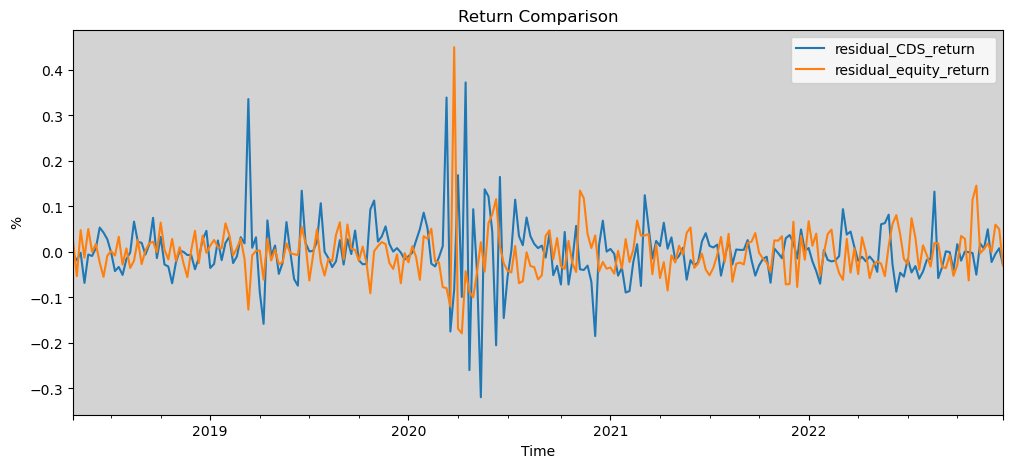

In [20]:
df_ba[['residual_CDS_return', 'residual_equity_return']].plot(title= "Return Comparison", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

In [21]:
df_ba['residual_equity_return'] = df_ba['residual_equity_return'].shift(1)
df_ba = df_ba.dropna()

After calculating the residual returns and shifting the equity residual returns, we can now form the two regressions and compare. The functions are derived from the Imitating_Update_Regressions_Boxcar_Exponential.ipynb. I provided the flexibility of choosing a different half-life for Exponentially Decaying Regression and a different window for Boxcar Regression. However, I will stick with half-life 12 and window size 16 for my analysis. 

In [22]:
def exp_reg(_df, exp_wts):
    _n = min(exp_wts.shape[0], _df.shape[0])
    _ldf = _df.iloc[-_n:]
    _wt = exp_wts[-_n:]
    _p = lm.WLS(_ldf['residual_CDS_return'], _ldf['residual_equity_return'], weights=_wt).fit(params_only=True).params
    return pd.DataFrame(data=[_p], index=[_df.index[-1]])

def exp_coef(_df, half_life):
    lma = 2**(-1./half_life)
    threshold = 1./(_df.shape[0]* 500)
    w = lma**np.arange(_df.shape[0]-1, -1, -1) 
    exp_wts = w[w > threshold] 
    enough_points = np.where(w > 1./20)[0].shape[0]
    exp_coeffs = pd.concat([exp_reg(_df.iloc[max(0,i-exp_wts.shape[0]):i], exp_wts) for i in range(enough_points, _df.shape[0])])
    exp_coeffs = exp_coeffs.rename(columns={'residual_equity_return': 'exp_beta'}) 
    return exp_coeffs

In [23]:
exp_coef(df_ba[['residual_CDS_return', 'residual_equity_return']], 12).head()

,exp_beta
2019-04-24,-0.339409
2019-05-01,-0.345242
2019-05-08,-0.355476
2019-05-15,-0.315893
2019-05-22,-0.375536


In [24]:
def boxcar_reg(_df):
    _p = lm.OLS(_df['residual_CDS_return'], _df['residual_equity_return']).fit(params_only=True).params
    return pd.DataFrame(data=[_p], index=[_df.index[-1]]) 

def boxcar_coef(_df, window): 
    boxcar_coef = pd.concat([boxcar_reg(_df.iloc[i-window:i]) for i in range(window, _df.shape[0])]) 
    boxcar_coef = boxcar_coef.rename(columns={'residual_equity_return': 'boxcar_beta'}) 
    return boxcar_coef

In [25]:
boxcar_coef(df_ba[['residual_CDS_return', 'residual_equity_return']], 16).head()

,boxcar_beta
2018-08-15,-0.573736
2018-08-22,-0.581641
2018-08-29,-0.642491
2018-09-05,-0.436867
2018-09-12,-0.444630


In [26]:
def predictive_result(df, half_life, window): 
    exp = exp_coef(df[['residual_CDS_return', 'residual_equity_return']], half_life)
    boxcar = boxcar_coef(df[['residual_CDS_return', 'residual_equity_return']], window) 
    result = df[['residual_CDS_return', 'residual_equity_return']].join(exp) 
    result = result.join(boxcar).dropna() 
    result['q_exp'] = result['residual_CDS_return'] - result['exp_beta'] * result['residual_equity_return'] 
    result['q_boxcar'] = result['residual_CDS_return'] - result['boxcar_beta'] * result['residual_equity_return'] 
    return result 

In [27]:
ba_predict = predictive_result(df_ba, 12, 16)
ba_predict.head()

,residual_CDS_return,residual_equity_return,exp_beta,boxcar_beta,q_exp,q_boxcar
date,,,,,,
2019-04-24,-0.008985,0.028514,-0.339409,-0.333455,0.000693,0.000523
2019-05-01,0.014075,-0.018721,-0.345242,-0.328009,0.007612,0.007935
2019-05-08,-0.048273,0.005155,-0.355476,-0.368899,-0.046441,-0.046372
2019-05-15,-0.023726,-0.027100,-0.315893,-0.331383,-0.032287,-0.032706
2019-05-22,0.065586,-0.022504,-0.375536,-0.383175,0.057135,0.056963


## Analysis

From the graph of the residuals of ticker BA, it seems that both predictive regressions performs equally good or bad. However, this may not be true for all the other tickers. Therefore, let's calculate q for all available tickers and draw the residual comparisons to compare the predicting power between the two regressions. 

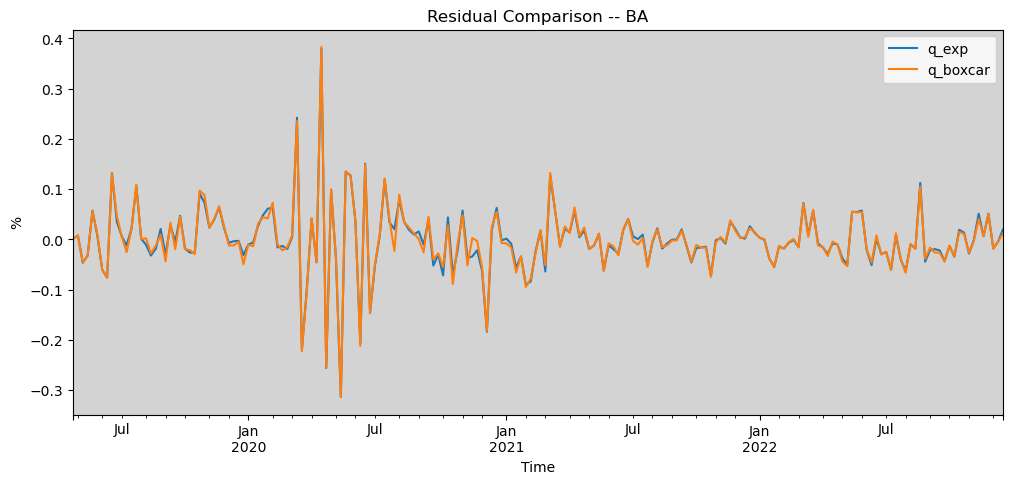

In [28]:
ba_predict[['q_exp', 'q_boxcar']].plot(title= "Residual Comparison -- BA", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

In [29]:
predict = ba_predict[['q_exp', 'q_boxcar']].rename(columns={'q_exp': 'BA_q_exp', 'q_boxcar': 'BA_q_boxcar'}) 
for ticker in tickers[1:]: 
    temp_cds = df_cds[[ticker, 'Index']].rename(columns={ticker: 'CDS'}) 
    temp_r_equity = r_equity[[ticker]].rename(columns={ticker: 'Equity'}) 
    df = temp_cds.join(temp_r_equity)
    df = df.join(r_spy).dropna()
    gamma = pd.concat([boxcar_16_reg_gamma(df.iloc[i-16:i]) for i in range(16, df.shape[0])]) 
    gamma = gamma.rename(columns={'SPY': 'Gamma'}) 
    coef = pd.concat([boxcar_16_reg(df.iloc[i-16:i]) for i in range(16, df.shape[0])]) 
    coef = coef.rename(columns={'Equity': 'beta_E', 'Index': 'beta_I'}) 
    df = df.join(gamma) 
    df = df.join(coef).dropna()
    df['f'] = df['Equity'] * df['beta_E'] + df['Index'] * df['beta_I']
    df['residual_CDS_return'] = df['CDS'] - df['f']
    df['residual_equity_return'] = df['Equity'] - df['Gamma'] * df['SPY'] 
    df['residual_equity_return'] = df['residual_equity_return'].shift(1)
    df = df.dropna()
    new = predictive_result(df, 12, 16)
    new = new[['q_exp', 'q_boxcar']].rename(columns={'q_exp': ticker+'_q_exp', 'q_boxcar': ticker+'_q_boxcar'}) 
    predict = predict.join(new) 

In [30]:
predict.head()

,BA_q_exp,BA_q_boxcar,C_q_exp,C_q_boxcar,DD_q_exp,DD_q_boxcar,F_q_exp,F_q_boxcar,GE_q_exp,GE_q_boxcar,...,T_q_exp,T_q_boxcar,WFC_q_exp,WFC_q_boxcar,XOM_q_exp,XOM_q_boxcar,XRX_q_exp,XRX_q_boxcar,NFLX_q_exp,NFLX_q_boxcar
date,,,,,,,,,,,,,,,,,,,,,
2019-04-24,0.000693,0.000523,0.008912,0.011189,-0.008570,-0.009053,-0.014539,-0.013899,0.056075,0.057472,...,0.004727,0.004858,0.017203,0.016595,0.001974,0.000175,0.013511,0.014911,0.0,0.0
2019-05-01,0.007612,0.007935,0.027792,0.024972,0.019853,0.021633,-0.072308,-0.072337,-0.014079,-0.013646,...,0.004701,0.009457,0.025593,0.024085,-0.000868,-0.002723,0.076579,0.073725,0.0,0.0
2019-05-08,-0.046441,-0.046372,0.024142,0.025339,0.047132,0.048352,0.047524,0.055295,-0.041693,-0.046763,...,0.001997,0.001949,0.021281,0.026657,0.004112,-0.001824,-0.066096,-0.067013,0.0,0.0
2019-05-15,-0.032287,-0.032706,-0.023472,-0.023483,0.004800,0.003876,-0.023578,-0.027580,-0.020029,-0.021545,...,-0.002269,-0.000935,-0.014222,-0.017942,0.022150,0.021077,-0.050003,-0.048550,0.0,0.0
2019-05-22,0.057135,0.056963,-0.003536,-0.003367,0.015831,0.015151,-0.000714,-0.003034,-0.063401,-0.064522,...,-0.007920,-0.011336,-0.015076,-0.016186,-0.008316,-0.004850,-0.006479,-0.003637,0.0,0.0


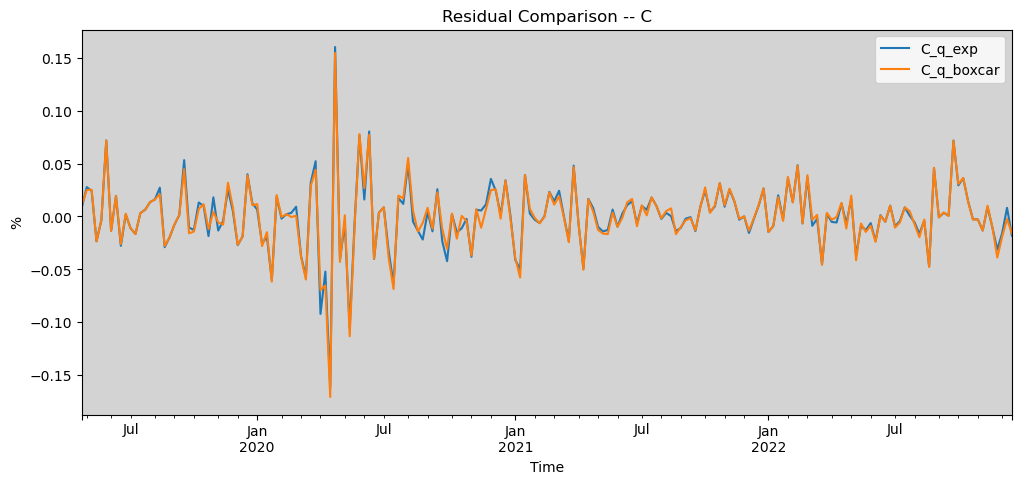

In [31]:
predict[['C_q_exp', 'C_q_boxcar']].plot(title= "Residual Comparison -- C", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

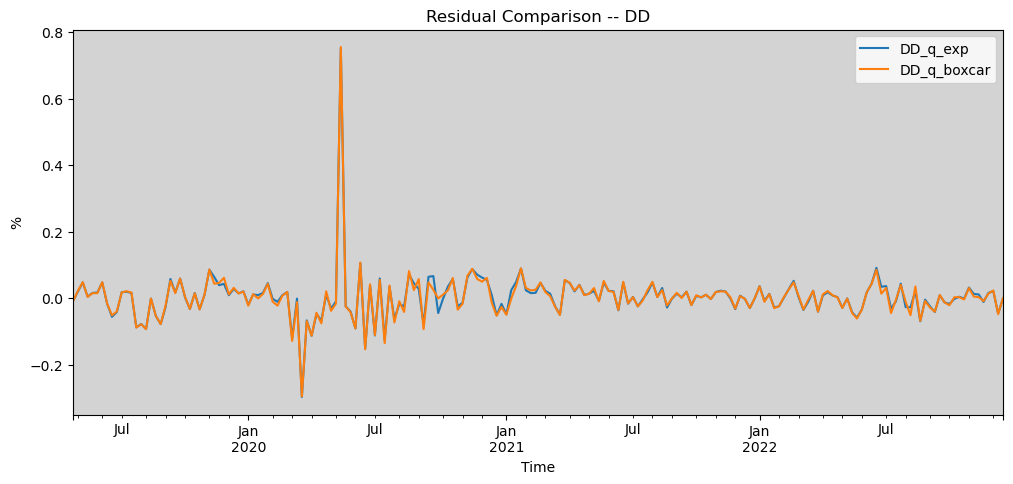

In [32]:
predict[['DD_q_exp', 'DD_q_boxcar']].plot(title= "Residual Comparison -- DD", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

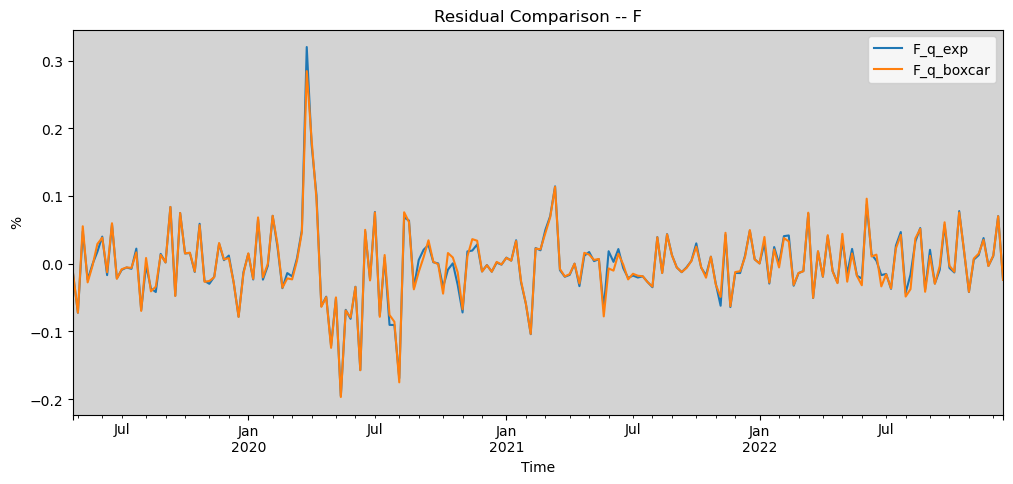

In [33]:
predict[['F_q_exp', 'F_q_boxcar']].plot(title= "Residual Comparison -- F", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

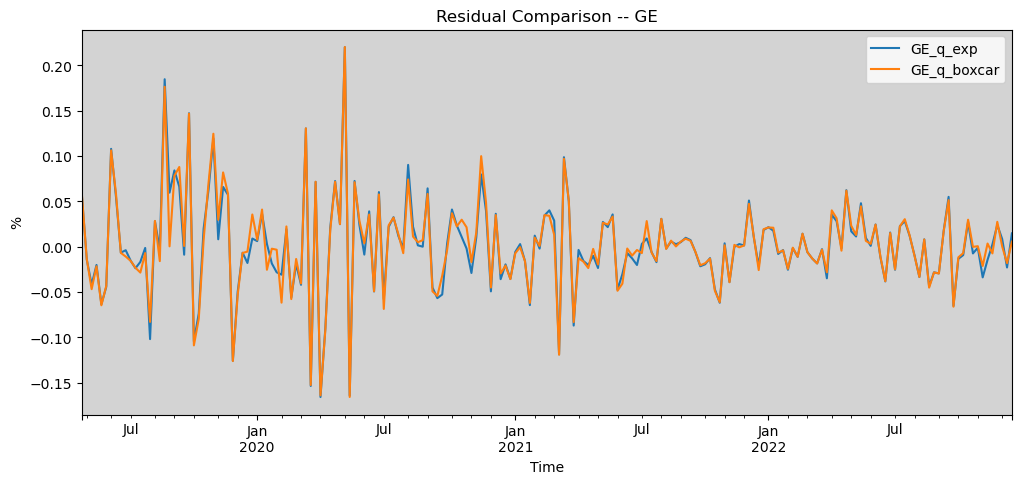

In [34]:
predict[['GE_q_exp', 'GE_q_boxcar']].plot(title= "Residual Comparison -- GE", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

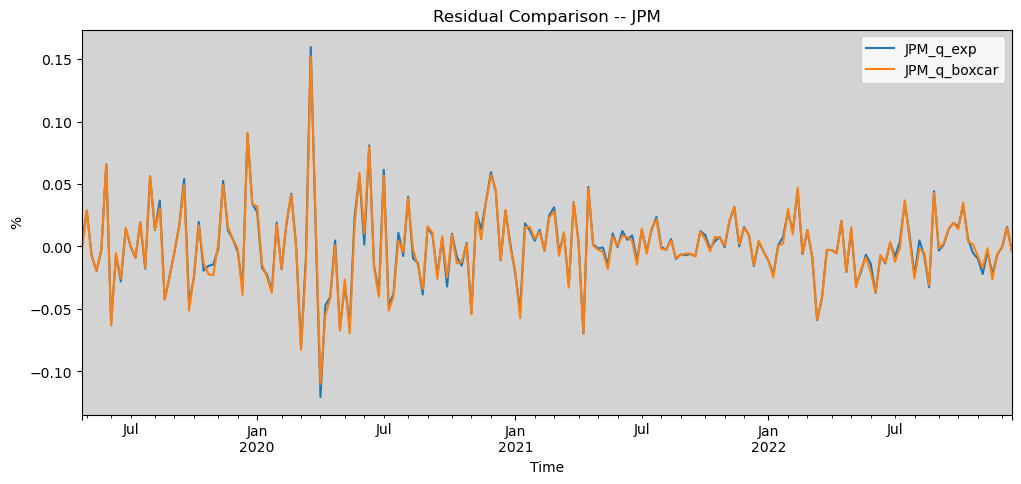

In [35]:
predict[['JPM_q_exp', 'JPM_q_boxcar']].plot(title= "Residual Comparison -- JPM", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

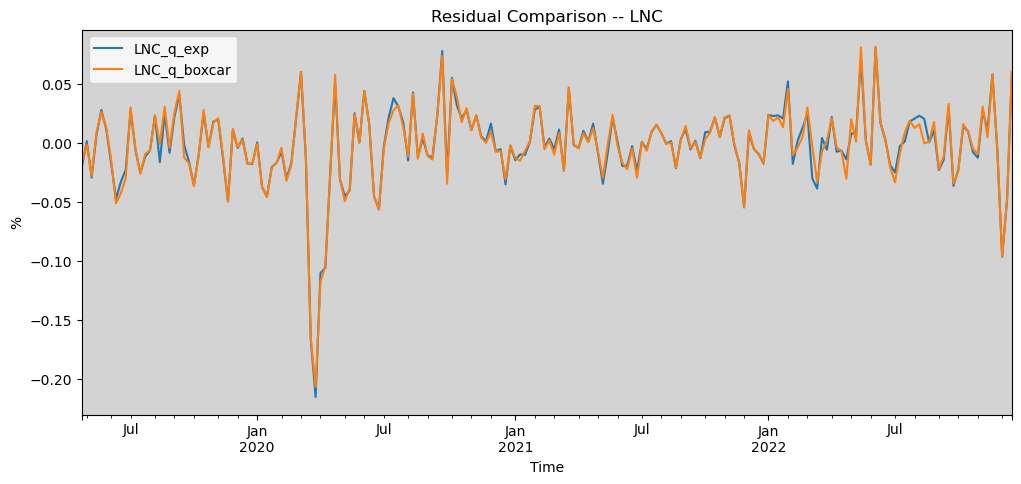

In [36]:
predict[['LNC_q_exp', 'LNC_q_boxcar']].plot(title= "Residual Comparison -- LNC", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

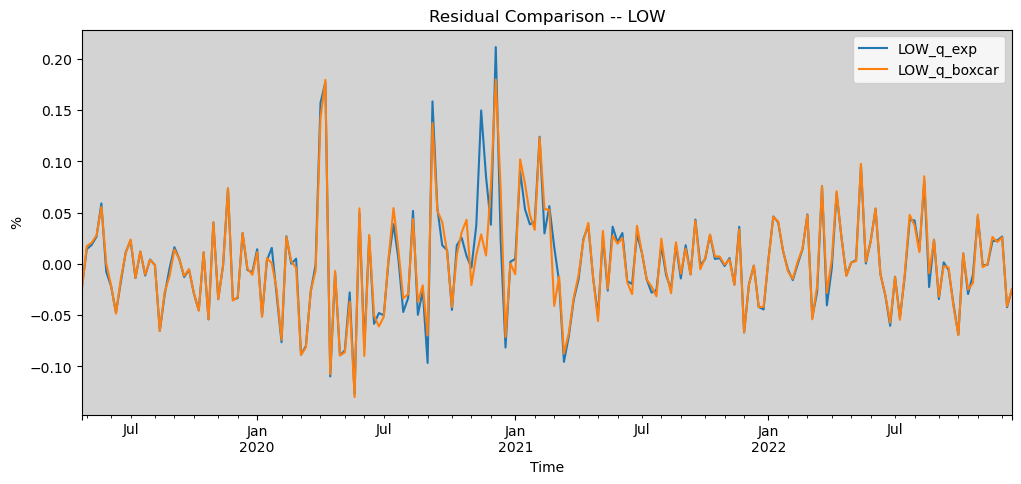

In [37]:
predict[['LOW_q_exp', 'LOW_q_boxcar']].plot(title= "Residual Comparison -- LOW", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

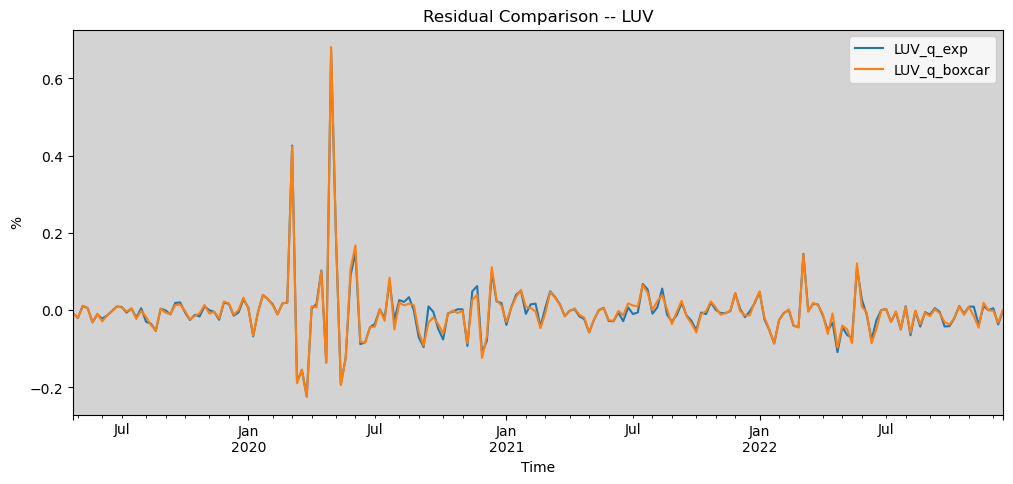

In [38]:
predict[['LUV_q_exp', 'LUV_q_boxcar']].plot(title= "Residual Comparison -- LUV", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

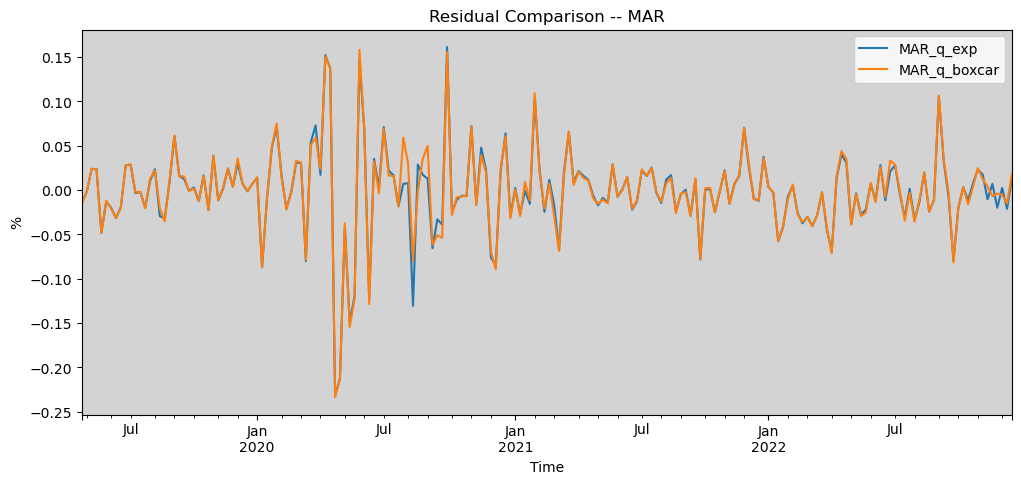

In [39]:
predict[['MAR_q_exp', 'MAR_q_boxcar']].plot(title= "Residual Comparison -- MAR", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

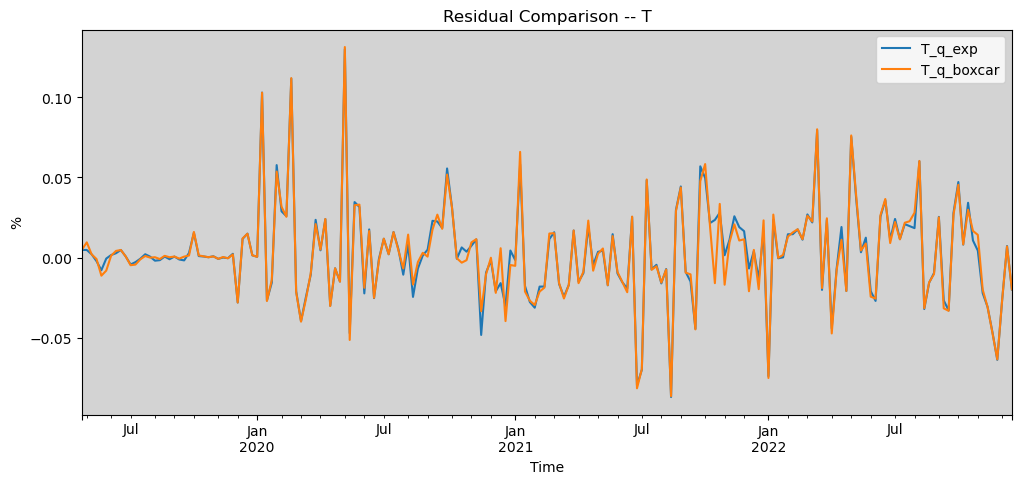

In [40]:
predict[['T_q_exp', 'T_q_boxcar']].plot(title= "Residual Comparison -- T", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

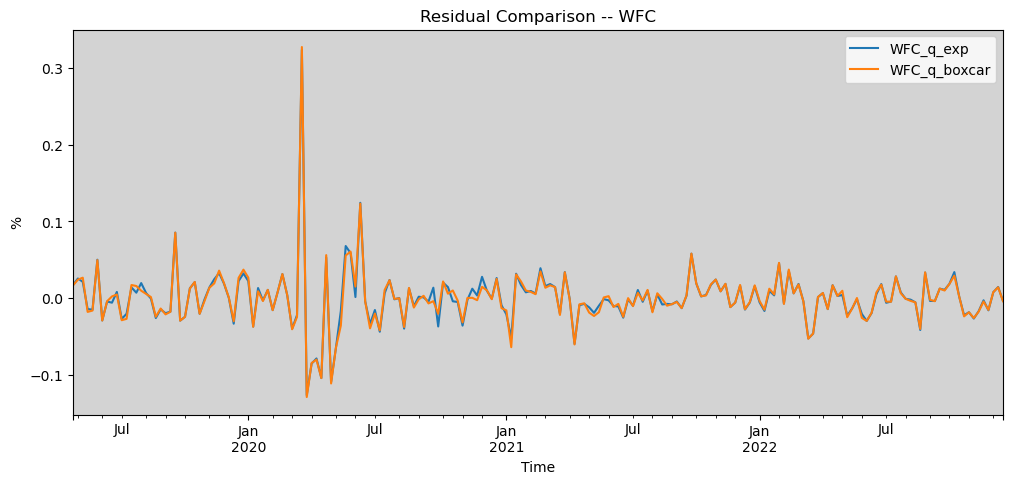

In [41]:
predict[['WFC_q_exp', 'WFC_q_boxcar']].plot(title= "Residual Comparison -- WFC", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

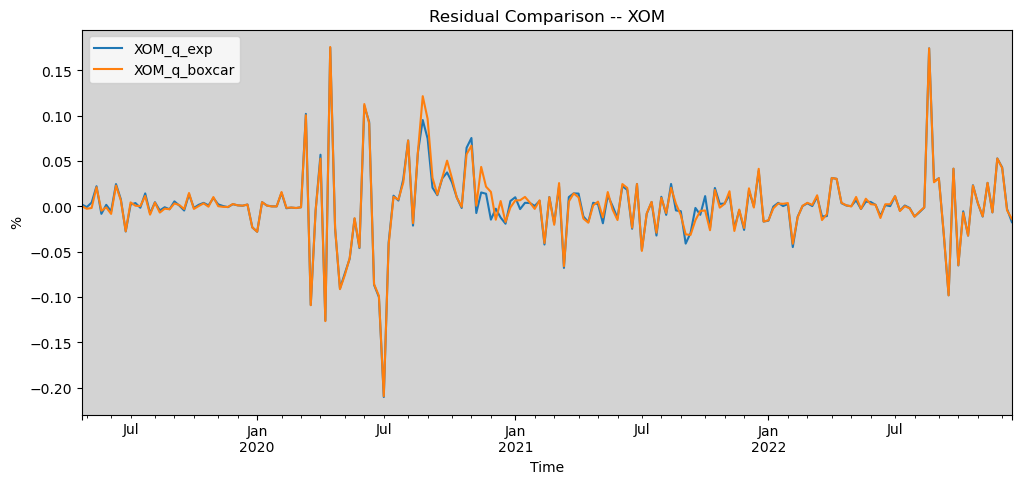

In [42]:
predict[['XOM_q_exp', 'XOM_q_boxcar']].plot(title= "Residual Comparison -- XOM", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

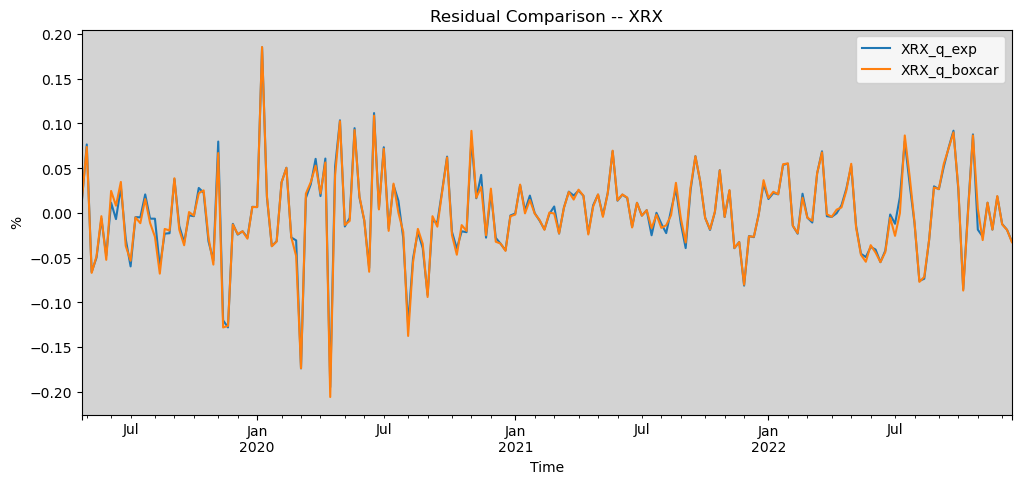

In [43]:
predict[['XRX_q_exp', 'XRX_q_boxcar']].plot(title= "Residual Comparison -- XRX", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

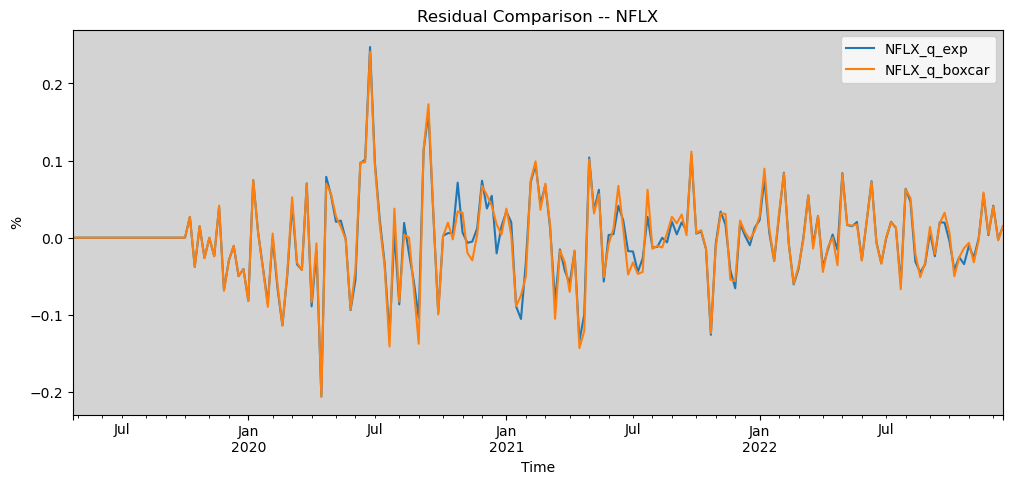

In [44]:
predict[['NFLX_q_exp', 'NFLX_q_boxcar']].plot(title= "Residual Comparison -- NFLX", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

From all the graphs above, we can see that both regressions predicts the data almost equally well. Even for NetFlix, as I have pointed out before, it has incomplete data, but its indication is the same as other tickers. 

This reconciled with the theory from lecture note: Little difference in weighting schemes on timescale much larger than the window. Therefore, we can choose to pick a different window size for boxcar and a different half-life for exponential decay to see if that distinguish between the prediction power of the two. To make the process simple, I will just choose ticker BA and select a different parameter. 

In [45]:
ba_predict_new1 = predictive_result(df_ba, 12, 4)
ba_predict_new1.head()

,residual_CDS_return,residual_equity_return,exp_beta,boxcar_beta,q_exp,q_boxcar
date,,,,,,
2019-04-24,-0.008985,0.028514,-0.339409,-1.142781,0.000693,0.023600
2019-05-01,0.014075,-0.018721,-0.345242,-1.075071,0.007612,-0.006051
2019-05-08,-0.048273,0.005155,-0.355476,-1.018518,-0.046441,-0.043023
2019-05-15,-0.023726,-0.027100,-0.315893,-0.065249,-0.032287,-0.025494
2019-05-22,0.065586,-0.022504,-0.375536,-0.831522,0.057135,0.046874


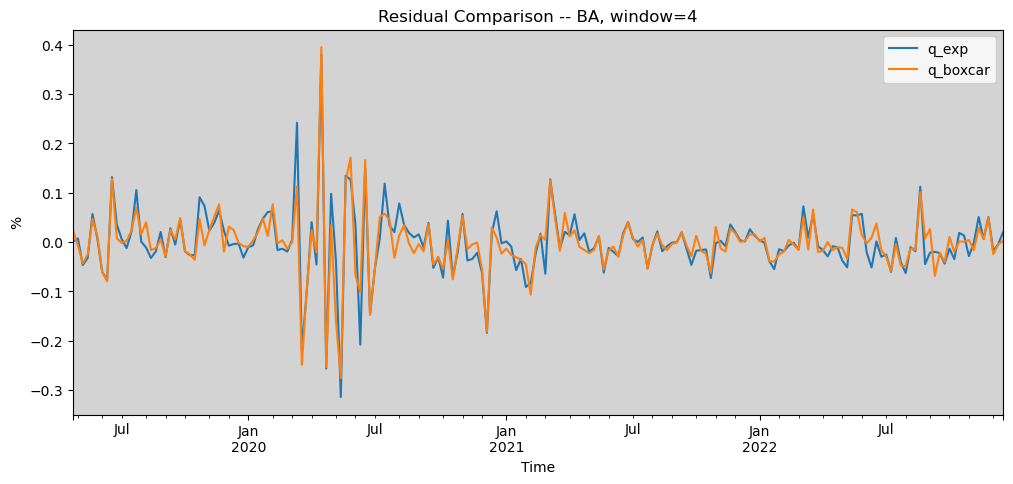

In [46]:
ba_predict_new1[['q_exp', 'q_boxcar']].plot(title= "Residual Comparison -- BA, window=4", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

In [47]:
ba_predict_new2 = predictive_result(df_ba, 12, 32)
ba_predict_new2.head()

,residual_CDS_return,residual_equity_return,exp_beta,boxcar_beta,q_exp,q_boxcar
date,,,,,,
2019-04-24,-0.008985,0.028514,-0.339409,-0.209801,0.000693,-0.003003
2019-05-01,0.014075,-0.018721,-0.345242,-0.249319,0.007612,0.009408
2019-05-08,-0.048273,0.005155,-0.355476,-0.250835,-0.046441,-0.046980
2019-05-15,-0.023726,-0.027100,-0.315893,-0.231258,-0.032287,-0.029993
2019-05-22,0.065586,-0.022504,-0.375536,-0.244967,0.057135,0.060073


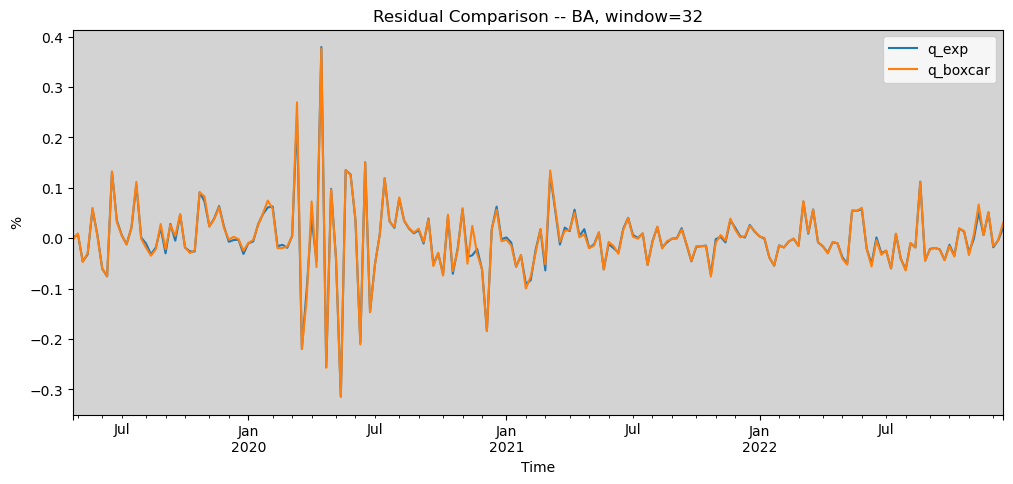

In [48]:
ba_predict_new2[['q_exp', 'q_boxcar']].plot(title= "Residual Comparison -- BA, window=32", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

In [49]:
ba_predict_new3 = predictive_result(df_ba, 6, 16)
ba_predict_new3.head()

,residual_CDS_return,residual_equity_return,exp_beta,boxcar_beta,q_exp,q_boxcar
date,,,,,,
2018-10-24,-0.068940,-0.016489,-0.167578,-0.269008,-0.071703,-0.073375
2018-10-31,-0.022819,0.028612,-0.242080,-0.301166,-0.015892,-0.014202
2018-11-07,0.003165,-0.019899,-0.237072,-0.321090,-0.001552,-0.003224
2018-11-14,0.000021,0.010415,-0.232717,-0.191453,0.002445,0.002015
2018-11-21,-0.006850,-0.025414,-0.178209,-0.220596,-0.011379,-0.012456


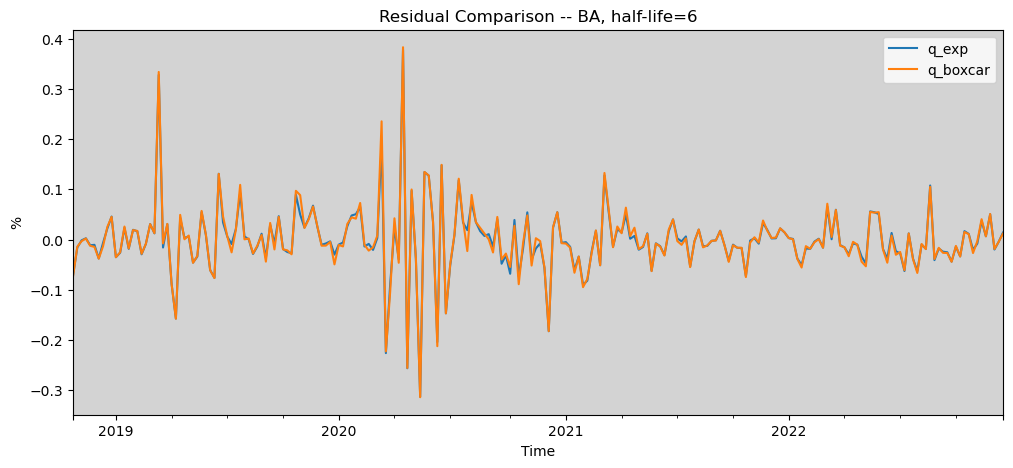

In [50]:
ba_predict_new3[['q_exp', 'q_boxcar']].plot(title= "Residual Comparison -- BA, half-life=6", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

In [51]:
ba_predict_new4 = predictive_result(df_ba, 24, 16)
ba_predict_new4.head()

,residual_CDS_return,residual_equity_return,exp_beta,boxcar_beta,q_exp,q_boxcar
date,,,,,,
2020-04-22,-0.259637,-0.042323,0.068564,0.094279,-0.256735,-0.255647
2020-04-29,0.093891,-0.088240,0.039260,0.065075,0.097355,0.099633
2020-05-06,-0.044810,-0.099637,0.052740,0.076135,-0.039555,-0.037224
2020-05-13,-0.319285,-0.044064,0.099983,0.121379,-0.314879,-0.313936
2020-05-20,0.137660,0.021330,0.110032,0.148610,0.135313,0.134490


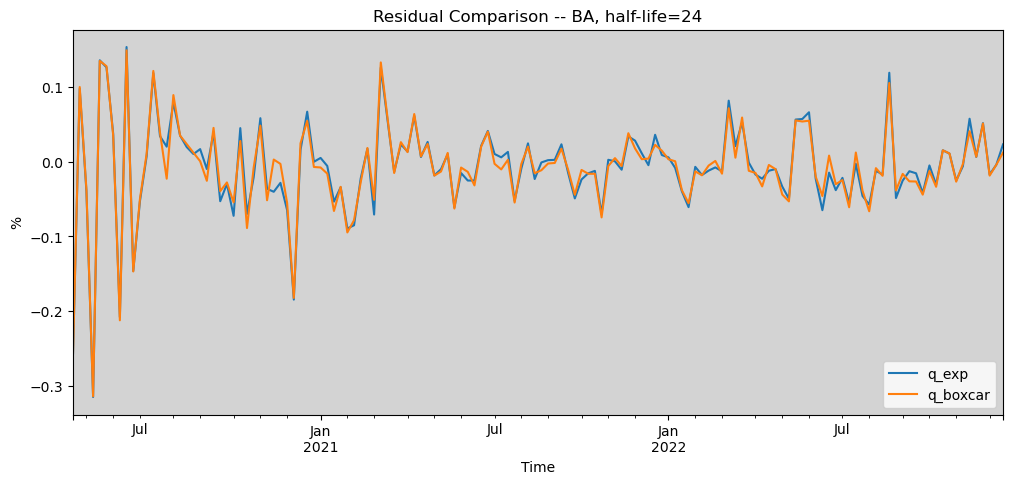

In [52]:
ba_predict_new4[['q_exp', 'q_boxcar']].plot(title= "Residual Comparison -- BA, half-life=24", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

From the graphs above, we can see that selecting smaller window size for boxcar makes its prediction have many differences to the exponential decay model. This suggests that no matter what the other metrics reflect, the exponentially decay model tends to give a more stable prediction. 

## Conclusion

The comparison between two regressions indicates the concepts introduced from lecture are actually correct. 

For example, the limitation of Boxcar is that when there is one volatile shift in the past, the Boxcar method might not be able to keep as the window moving forward. This might be tragic for us to track the data if the window passed by this volatile point, we might experience a large shift back. 

On the other hand, exponentially decay can keep tracking all historical data points by utilizing a mathematical formula: 

$$ \frac{1}{(1+x+x^2+x^3+...)}= 1-x $$ 

After a list of derivation, we also see that for exponentially decay method has a low computation cost as we can update the new regression points by simply using the unit decay factor for each update. 

To improve our result, we can consider more metrics to check. For example, we can keep tracking a rolling $R^2$ to see if the exponentially decay actually has an improving performance. That is, while doing the regressions, we can not only keep all $\mu$, but also keep all $R^2$, this might give us a better understanding that as time passes, our predictions become more representative to the actual data. 

Also, we should aware that the although for most of the tickers and parameters we select, the predictive patterns are almost exactly the same. However, this is the result when we look at the prediction for 3-4 years as a whole. From the lecture, we know that the comparison between the two should be zoomed into a smaller time interval. If we consider about the daily trading, and only look at a smaller period, we still cannot say Boxcar is as good as Exponential Decay method. 

E.g. Consider the a period of 15 days: 

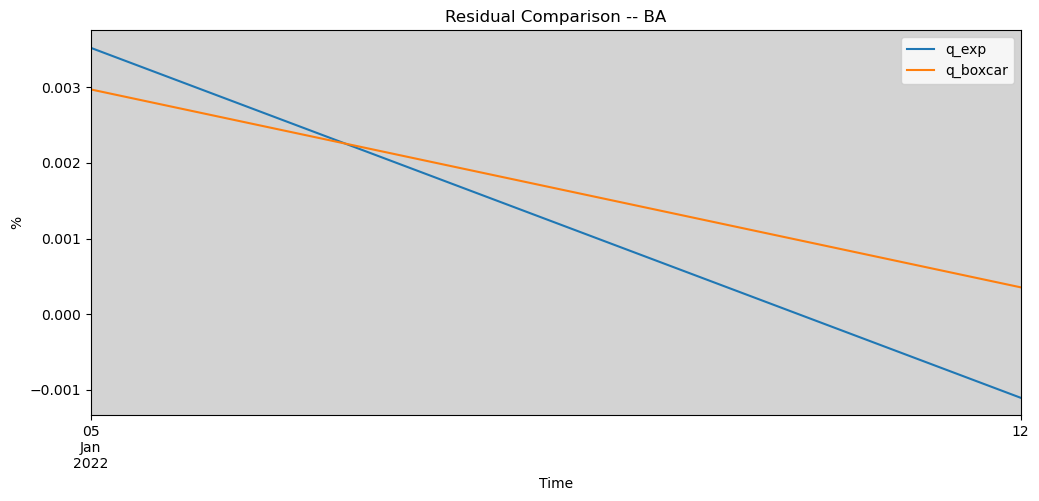

In [53]:
ba_predict[['q_exp', 'q_boxcar']]['2022-01-01':'2022-01-15'].plot(title= "Residual Comparison -- BA", ylabel = "%", xlabel = "Time", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

This shows very little details as our returns are weekly data. If we use the daily returns, we might be able to see the difference in prediction power of the two methods. 